In this part, we are going to use LLM to read all the previous news and history price, volume, and value to make a prediction on the next step price and generate the reasoning.

We would like to see how LLMs understand the market behavior and does that makes a good prediction than algorithms.

In [11]:
!pip install -q -U google-generativeai
!pip install openai
!pip install anthropic

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from google.colab import userdata
from google.colab import drive
from sklearn.metrics import mean_squared_error, f1_score

drive.mount('/content/drive')

# Load the JSON file
news_path = "/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Data_news/all_news.json"

# Read the JSON file
try:
    with open(news_path, 'r', encoding='utf-8') as f:
        all_news = json.load(f)
except FileNotFoundError:
    raise Exception(f"File not found: {file_path}")
except json.JSONDecodeError:
    raise Exception("Error decoding JSON. Please check the file content.")

if isinstance(all_news, list):
    all_news = pd.DataFrame(all_news)

price_path = "/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/LCFS_task/LCFS_monthly.csv"
lcfs = pd.read_csv(price_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
all_news['date'] = pd.to_datetime(all_news['date'])
all_news['date'] = all_news['date'].dt.strftime('%Y-%m-%d')
all_news

,date,source,title,second_title,content
0,2010-02-02,The California Air Resources Board,ARB Chairman Mary Nichols issues comment on la...,None,In response to a lawsuit brought by the Natio...
1,2010-02-03,The California Air Resources Board,ARB applauds EPA’s renewable fuels announcement,None,In response to the announcement made today by ...
2,2011-12-16,The California Air Resources Board,Air Resources Board moves forward with clean f...,"Adopts changes to streamline, add flexibility ...",The California Air Resources Board voted today...
3,2012-04-23,The California Air Resources Board,U.S. Court of Appeals Allows Enforcement of Ca...,Ninth Circuit will next consider ARB appeal of...,Today the Ninth Circuit U.S. Court of Appeals ...
4,2015-02-20,The California Air Resources Board,Air Resources Board considers improved clean f...,Regulation sends a clear signal to industry en...,The Air Resources Board yesterday held the fir...
...,...,...,...,...,...
656,2024-11-01,Journal of Petroleum Technology,The Ones and Zeros of Carbon Capture,None,The road to a low-carbon world is paved with m...
657,2024-11-01,Journal of Petroleum Technology,Polymer-Injection Pilot in Colombian Field Ind...,None,This paper describes a polymer-injection pilot...
658,2024-11-01,Journal of Petroleum Technology,Study Assesses Effects of Carbon Dioxide on Dr...,None,This paper aims to close some of the many know...
659,2024-11-01,Journal of Petroleum Technology,Petroleum Engineering Research Shifts Focus Fr...,None,Undergraduate education in petroleum engineeri...


In [10]:
lcfs['Value'] = lcfs['Price'] * lcfs['Volume']
lcfs['Date'] = pd.to_datetime(lcfs['Date'])
lcfs['Date'] = lcfs['Date'].dt.strftime('%Y-%m-%d')
lcfs.drop(columns=['Unnamed: 0'], inplace=True)
lcfs

,Date,Price,Volume,Value
0,2013-01-13,22.0,24000,528000.0
1,2013-02-13,27.0,36000,972000.0
2,2013-03-13,34.0,48000,1632000.0
3,2013-04-13,35.0,42000,1470000.0
4,2013-05-13,45.0,7000,315000.0
...,...,...,...,...
137,2024-06-24,51.0,1543000,78693000.0
138,2024-07-24,57.0,6283000,358131000.0
139,2024-08-24,54.0,2155000,116370000.0
140,2024-09-24,60.0,3022000,181320000.0


In [11]:
def evaluation(y_pred, y):
    # Mean standard error
    mse = np.sum((y_pred - y)**2.0)

    # Mean prediction accuracy
    within_threshold = np.abs(y_pred - y) / y
    mpa = np.mean(1 - within_threshold) * 100  # convert to percentage

    true_trend = np.sign(np.diff(y))  # +1 for upward, -1 for downward
    predicted_trend = np.sign(np.diff(y_pred))

    # F-1 Score
    f1 = f1_score(true_trend, predicted_trend, average='macro')

    # movement direction accuracy
    correct_trend = true_trend == predicted_trend
    mda = np.mean(correct_trend) * 100  # convert to percentage

    return {
        'MSE': mse,
        'MPA (%)': mpa,
        'F1 Score': f1,
        'MDA (%)': mda}


## Gemini Pro

In [ ]:
import google.generativeai as genai
import re

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

output_file = "/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/LCFS_task/price_pred_gemini.csv"

model = genai.GenerativeModel('gemini-1.5-pro')


In [ ]:
import time
import random

def model_generate_prediction(prompt, retries=5):
    for attempt in range(retries):
        try:
            response = model.generate_content(prompt)
            return response.text
        except Exception as e:
            if "429" in str(e):
                wait_time = 2 ** attempt + random.uniform(0, 1)
                print(f"Rate limit hit. Retrying in {wait_time:.2f} seconds...")
                time.sleep(wait_time)
            else:
                raise e
    raise Exception("Maximum retry limit reached.")


def rolling_prediction(lcfs, news, start):
    results = []
    count   = 0

    date_range = lcfs['Date'][:start]
    history_prices = lcfs['Price'][:start]
    history_volumes = lcfs['Volume'][:start]
    history_values = lcfs['Value'][:start]

    predictions = []

    for t in range(start, len(lcfs)):
        current_date = lcfs['Date'].iloc[t]
        relevant_news = news[news['date'] <= current_date]
        news_to_current_date = "\n".join(
            f"Date: {row['date']}\nTitle: {row['title']}"
            for _, row in relevant_news.iterrows()
        )

        # Create the prompt
        prompt = (
                  f"You are an expert in carbon marketing analysis and LCFS carbon price forecasting.\n"
                  f"Your task is to predict the LCFS price for the next time step based on the following inputs:\n"
                  f"1. Historical prices, volumes, and values of LCFS credits.\n"
                  f"2. Relevant news articles impacting the LCFS market dynamics.\n"
                  f"Consider these factors:\n"
                  f"1. Analyze historical trends in prices, volumes, and values.\n"
                  f"2. Incorporate the impact of news articles on LCFS market conditions (e.g., policy changes, supply/demand shifts).\n"
                  f"3. Predict the next price while considering both historical data patterns and news impact.\n"
                  f"4. Make reasoning of your prediction.\n"
                  f"Output the prediction in the format:\n"
                  f"(Price: <price>, Reason: <reason>)"
                  f"\n"
                  f"Here is the data to evaluate:\n"
                  f"Historical prices, volumes, values, and related news\n"
                  f"Hisrotical dates list: {list(date_range)},\n"
                  f"Corresponding prices list: {list(history_prices)},\n"
                  f"Corresponding volumes list: {list(history_volumes)},\n"
                  f"Corresponding values list: {list(history_values)}.\n\n"
                  f"Here are relevant News:\n"
                  f"{news_to_current_date}.\n"
                  f"Please predict the LCFS price for the next time step and make reasoning in the format: \n"
                  f"(Price: <price>, Reason: <reason>)."
                  )


        # f"{news_to_current_date}.\n"

        # Get response from the model
        response = model_generate_prediction(prompt)

        count += 1
        #if count % 10 == 0:
        print(f"Processed promt: {count}")

        date_range = np.append(date_range, current_date)
        history_prices = np.append(history_prices, lcfs['Price'].iloc[t])
        history_volumes = np.append(history_volumes, lcfs['Volume'].iloc[t])
        history_values = np.append(history_values, lcfs['Value'].iloc[t])

        price = None
        reason = None

        try:
            # Extract the price string
            price_start = response.find("Price: ") + len("Price: ")
            price_end = response.find(",", price_start)
            price_str = response[price_start:price_end].strip()

            # Remove the dollar sign if present, and convert to float
            price = float(price_str.replace("$", "")) if "$" in price_str else float(price_str)

            # Extract the reasoning
            reason_start = response.find("Reason: ") + len("Reason: ")
            reason = response[reason_start:response.find("\n", reason_start)].strip()

            print(f"Extracted Price: {price}")
            print(f"Extracted Reason: {reason}")
        except Exception as e:
            print(f"Error processing response: {response}. Error: {e}")
            price = None
            reason = "Error in response format"

        # Append the predictions
        predictions.append({
            "date": current_date,
            "price": price,
            "reason": reason})
    return predictions


Processed promt: 1
Extracted Price: 25.0
Extracted Reason: The historical data reveals a generally upward trend in LCFS credit prices from 2013 to mid-2014, followed by a decline.  The volumes traded show significant fluctuations, and the total value reflects the interplay of price and volume.  While news articles from 2010-2012 demonstrate strengthening support and legal certainty for the LCFS, the more recent news from 2013-2014 focuses on CO2 sequestration technologies. These technologies could potentially increase the supply of LCFS credits in the future, putting downward pressure on prices. The most recent prices show a downward trend (28.0, 29.0), and given the increasing volumes coupled with emerging technologies that could increase credit supply, a further price decrease is likely. Therefore, a price of 25.0 is a reasonable prediction, representing a continued moderate decline. This prediction considers the most recent downward trend and potential future impacts of emerging tec

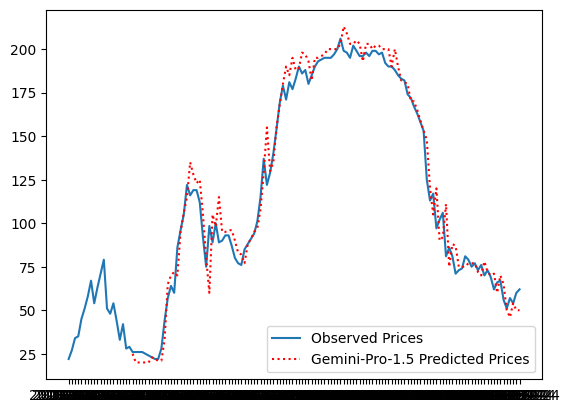

{'MSE': 11561.560000000001, 'MPA (%)': 92.43714361336181, 'F1 Score': 0.37317857083381906, 'MDA (%)': 42.97520661157025}


In [ ]:
start_index = 20

predictions = rolling_prediction(lcfs, all_news, start_index)

predicted_prices = [pred['price'] for pred in predictions]

# Plot original vs. predicted prices
plt.plot(lcfs['Date'], lcfs['Price'], label='Observed Prices')
plt.plot(lcfs['Date'][start_index:], predicted_prices, label='Gemini-Pro-1.5 Predicted Prices', color='r', linestyle=':')
plt.legend()
plt.savefig('/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/LCFS_task/gemini+news_pred.png', dpi=300)
plt.show()

print(evaluation(predicted_prices, lcfs['Price'][start_index:]))


In [ ]:
dates = lcfs['Date'][start_index:]  # Corresponding dates for the predictions

df_predictions = pd.DataFrame({
    'Date': dates,
    'Predicted_Price': predicted_prices,
    'Reason': [pred['reason'] for pred in predictions]
})

df_predictions.to_csv('/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/LCFS_task/gemini+news_pred.csv', index=False)

# Claude

In [ ]:
import anthropic
from typing import List, Dict, Any
import re


# Retrieve your API key
CLAUDE_API_KEY = userdata.get('CLAUDE_API_KEY')
client = anthropic.Anthropic(api_key=CLAUDE_API_KEY)

output_file = "/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/LCFS_task/price_pred_claude.csv"

In [ ]:
import time
import random

def get_claude_response(api_key, role, prompt,
                       model: str = "claude-3-5-sonnet-20241022",
                       max_tokens: int = 8192) -> str:
  client = anthropic.Anthropic(api_key=api_key)

  response = client.messages.create(
      model=model,
      max_tokens=max_tokens,
      system=role,
      messages=prompt)
  return response.content[0].text


def claude_rolling_prediction(lcfs, news, start):
    results = []
    count   = 0

    date_range = lcfs['Date'][:start]
    history_prices = lcfs['Price'][:start]
    history_volumes = lcfs['Volume'][:start]
    history_values = lcfs['Value'][:start]

    predictions = []

    for t in range(start, len(lcfs)):
        current_date = lcfs['Date'].iloc[t]
        relevant_news = news[news['date'] <= current_date]
        news_to_current_date = "\n".join(
            f"Date: {row['date']}\nTitle: {row['title']}"
            for _, row in relevant_news.iterrows()
        )

        # Create the prompt
        role   = (
            f"You are an expert in carbon marketing analysis and LCFS carbon price forecasting.\n"
            f"Your task is to predict the LCFS price for the next time step based on the following inputs:\n"
            f"1. Historical prices, volumes, and values of LCFS credits.\n"
            f"2. Relevant news articles impacting the LCFS market dynamics.\n"
            f"Consider these factors:\n"
            f"1. Analyze historical trends in prices, volumes, and values.\n"
            f"2. Incorporate the impact of news articles on LCFS market conditions (e.g., policy changes, supply/demand shifts).\n"
            f"3. Predict the next price while considering both historical data patterns and news impact.\n"
            f"4. Make reasoning of your prediction.\n"
            f"Output the prediction in the format:\n"
            f"(Price: <price>, Reason: <reason>)"
            )

        prompt = [{"role": "user",
                   "content": (
                      f"Here is the data to evaluate:\n"
                      f"Historical prices, volumes, values, and related news\n"
                      f"Hisrotical dates list: {list(date_range)},\n"
                      f"Corresponding prices list: {list(history_prices)},\n"
                      f"Corresponding volumes list: {list(history_volumes)},\n"
                      f"Corresponding values list: {list(history_values)}.\n\n"
                      f"Here are relevant News:\n"
                      f"{news_to_current_date}.\n"
                      f"Please predict the LCFS price for the next time step and make reasoning in the format: \n"
                      f"(Price: <price>, Reason: <reason>)."
                      )
                   }]

        # Get response from the model
        response = get_claude_response(
            api_key=CLAUDE_API_KEY,
            role=role,
            prompt=prompt)

        count += 1
        #if count % 10 == 0:
        print(f"Processed promt: {count}")

        date_range = np.append(date_range, current_date)
        history_prices = np.append(history_prices, lcfs['Price'].iloc[t])
        history_volumes = np.append(history_volumes, lcfs['Volume'].iloc[t])
        history_values = np.append(history_values, lcfs['Value'].iloc[t])

        price = None
        reason = None

        try:
            # Extract the price string
            price_start = response.find("Price: ") + len("Price: ")
            price_end = response.find(",", price_start)
            price_str = response[price_start:price_end].strip()

            # Remove the dollar sign if present, and convert to float
            price = float(price_str.replace("$", "")) if "$" in price_str else float(price_str)

            # Extract the reasoning
            reason_start = response.find("Reason: ") + len("Reason: ")
            reason = response[reason_start:].strip()

            print(f"Extracted Price: {price}")
            #print(f"Extracted Reason: {reason}")
        except Exception as e:
            print(f"Error processing response: {response}. Error: {e}")
            price = None
            reason = "Error in response format"

        # Append the predictions
        predictions.append({
            "date": current_date,
            "price": float(price),
            "reason": str(reason)})
    return predictions


Processed promt: 1
Extracted Price: 31.0
Processed promt: 2
Extracted Price: 24.0
Processed promt: 3
Extracted Price: 24.0
Processed promt: 4
Extracted Price: 24.0
Processed promt: 5
Extracted Price: 24.0
Processed promt: 6
Extracted Price: 24.0
Processed promt: 7
Extracted Price: 23.0
Processed promt: 8
Extracted Price: 21.0
Processed promt: 9
Extracted Price: 21.0
Processed promt: 10
Extracted Price: 21.0
Processed promt: 11
Extracted Price: 30.0
Processed promt: 12
Extracted Price: 48.0
Processed promt: 13
Extracted Price: 65.0
Processed promt: 14
Extracted Price: 71.0
Processed promt: 15
Extracted Price: 57.0
Processed promt: 16
Extracted Price: 92.0
Processed promt: 17
Extracted Price: 105.0
Processed promt: 18
Extracted Price: 112.0
Processed promt: 19
Extracted Price: 135.0
Processed promt: 20
Extracted Price: 120.0
Processed promt: 21
Extracted Price: 123.0
Processed promt: 22
Extracted Price: 123.0
Processed promt: 23
Extracted Price: 108.0
Processed promt: 24
Extracted Price:

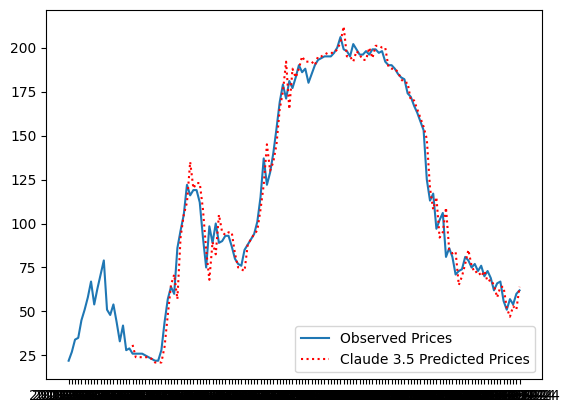

{'MSE': 9392.91, 'MPA (%)': 93.64099317141812, 'F1 Score': 0.39444444444444443, 'MDA (%)': 43.80165289256198}


In [ ]:
start_index = 20

predictions = claude_rolling_prediction(lcfs, all_news, start_index)

predicted_prices = [pred['price'] for pred in predictions]

# Plot original vs. predicted prices
plt.plot(lcfs['Date'], lcfs['Price'], label='Observed Prices')
plt.plot(lcfs['Date'][start_index:], predicted_prices, label='Claude 3.5 Predicted Prices', color='r', linestyle=':')
plt.legend()
plt.savefig('/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/LCFS_task/Claude+news_pred.png', dpi=300)
plt.show()

print(evaluation(predicted_prices, lcfs['Price'][start_index:]))

In [ ]:
dates = lcfs['Date'][start_index:]  # Corresponding dates for the predictions

df_predictions = pd.DataFrame({
    'Date': dates,
    'Predicted_Price': predicted_prices,
    'Reason': [pred['reason'] for pred in predictions]
})

df_predictions.to_csv('/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/LCFS_task/claude+news_pred.csv', index=False)

# GPT4o

In [4]:
import os
from openai import OpenAI
from google.colab import userdata
import pandas as pd
import json
import asyncio

output_file = "/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Data_news/price_pred_gpt4o.csv"

# Retrieve your API key
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

client = OpenAI.api_key=OPENAI_API_KEY


In [37]:
pip install --upgrade --upgrade-strategy eager "regex" "charset-normalizer<4" "idna" "urllib3<3" "certifi" "requests" "anyio<5" "distro<2" "sniffio" "h11<0.15" "httpcore==1.*"  "annotated-types" "typing-extensions<5" "pydantic-core==2.27.1" "pydantic<3" "jiter<1" "tqdm" "colorama" "openai" "tiktoken" "httpx<0.28"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.1 MB/s eta 0:00:00
  Using cached httpx-0.27.2-py3-none-any.whl.metadata (7.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.0/457.0 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.5 MB/s eta 0:00:00
Using cached httpx-0.27.2-py3-none-any.whl (76 kB)
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.6
    Uninstalling tqdm-4.66.6:
      Successfully uninstalled tqdm-4.66.6
  Attempting uninstall: regex
    Found existing installation: regex 2024.9.11
    Uninstalling regex-

In [5]:
from openai import OpenAI

client = OpenAI(api_key=OPENAI_API_KEY)

stream = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "Say this is a test",
        }
    ],
    model="gpt-4o",
    stream=True,
)
for chunk in stream:
    print(chunk.choices[0].delta.content or "", end="")

This is a test.

In [12]:
def gpt4o_generate_content(prompt):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=prompt
        )
    return response.choices[0].message.content

def gpt4o_rolling_prediction(lcfs, news, start):
    results = []
    count   = 0

    date_range = lcfs['Date'][:start]
    history_prices = lcfs['Price'][:start]
    history_volumes = lcfs['Volume'][:start]
    history_values = lcfs['Value'][:start]

    predictions = []

    for t in range(start, len(lcfs)):
        current_date = lcfs['Date'].iloc[t]
        relevant_news = news[news['date'] <= current_date]
        news_to_current_date = "\n".join(
            f"Date: {row['date']}\nTitle: {row['title']}"
            for _, row in relevant_news.iterrows()
        )

        # Create the prompt
        prompt = [{"role": "system",
                   "content": (
                       f"You are an expert in carbon marketing analysis and LCFS carbon price forecasting.\n"
                       f"Your task is to predict the LCFS price for the next time step based on the following inputs:\n"
                       f"1. Historical prices, volumes, and values of LCFS credits.\n"
                       f"2. Relevant news articles impacting the LCFS market dynamics.\n"
                       f"Consider these factors:\n"
                       f"1. Analyze historical trends in prices, volumes, and values.\n"
                       f"2. Incorporate the impact of news articles on LCFS market conditions (e.g., policy changes, supply/demand shifts).\n"
                       f"3. Predict the next price while considering both historical data patterns and news impact.\n"
                       f"4. Make reasoning of your prediction.\n"
                       f"Output the prediction in the format:\n"
                       f"(Price: <price>, Reason: <reason>)"
                    )
                },
                  {"role": "user",
                   "content": (
                       f"Here is the data to evaluate:\n"
                       f"Historical prices, volumes, values, and related news\n"
                       f"Hisrotical dates list: {list(date_range)},\n"
                       f"Corresponding prices list: {list(history_prices)},\n"
                       f"Corresponding volumes list: {list(history_volumes)},\n"
                       f"Corresponding values list: {list(history_values)}.\n\n"
                       f"Here are relevant News:\n"
                       f"{news_to_current_date}.\n"
                       f"Please predict the LCFS price for the next time step and make reasoning in the format: \n"
                       f"(Price: <price>, Reason: <reason>)."
                      )
                   }]

        # Get response from the model
        response = gpt4o_generate_content(prompt)

        count += 1
        #if count % 10 == 0:
        print(f"Processed promt: {count}")

        date_range = np.append(date_range, current_date)
        history_prices = np.append(history_prices, lcfs['Price'].iloc[t])
        history_volumes = np.append(history_volumes, lcfs['Volume'].iloc[t])
        history_values = np.append(history_values, lcfs['Value'].iloc[t])

        price = None
        reason = None

        try:
            # Extract the price string
            price_start = response.find("Price: ") + len("Price: ")
            price_end = response.find(",", price_start)
            price_str = response[price_start:price_end].strip()

            # Remove the dollar sign if present, and convert to float
            price = float(price_str.replace("$", "")) if "$" in price_str else float(price_str)

            # Extract the reasoning
            reason_start = response.find("Reason: ") + len("Reason: ")
            reason = response[reason_start:].strip()

            print(f"Extracted Price: {price}")
            #print(f"Extracted Reason: {reason}")
        except Exception as e:
            print(f"Error processing response: {response}. Error: {e}")
            price = None
            reason = "Error in response format"

        # Append the predictions
        predictions.append({
            "date": current_date,
            "price": float(price),
            "reason": str(reason)})
    return predictions

Processed promt: 1
Extracted Price: 36.0
Processed promt: 2
Extracted Price: 32.0
Processed promt: 3
Extracted Price: 28.0
Processed promt: 4
Extracted Price: 30.0
Processed promt: 5
Extracted Price: 28.0
Processed promt: 6
Extracted Price: 26.0
Processed promt: 7
Extracted Price: 23.0
Processed promt: 8
Extracted Price: 22.0
Processed promt: 9
Extracted Price: 21.0
Processed promt: 10
Extracted Price: 22.0
Processed promt: 11
Extracted Price: 27.0
Processed promt: 12
Extracted Price: 46.0
Processed promt: 13
Extracted Price: 50.0
Processed promt: 14
Extracted Price: 68.0
Processed promt: 15
Extracted Price: 62.0
Processed promt: 16
Extracted Price: 82.0
Processed promt: 17
Extracted Price: 105.0
Processed promt: 18
Extracted Price: 108.0
Processed promt: 19
Extracted Price: 125.0
Processed promt: 20
Extracted Price: 126.0
Processed promt: 21
Extracted Price: 110.0
Processed promt: 22
Extracted Price: 115.0
Processed promt: 23
Extracted Price: 115.0
Processed promt: 24
Extracted Price:

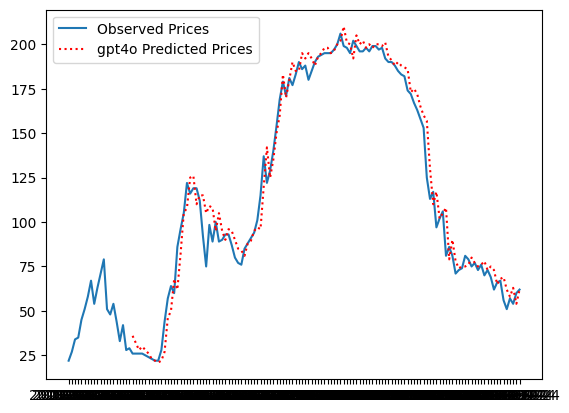

{'MSE': 10734.86, 'MPA (%)': 92.4110301048272, 'F1 Score': 0.3897492625368732, 'MDA (%)': 49.586776859504134}


In [13]:
start_index = 20

predictions = gpt4o_rolling_prediction(lcfs, all_news, start_index)

predicted_prices = [pred['price'] for pred in predictions]

# Plot original vs. predicted prices
plt.plot(lcfs['Date'], lcfs['Price'], label='Observed Prices')
plt.plot(lcfs['Date'][start_index:], predicted_prices, label='gpt4o Predicted Prices', color='r', linestyle=':')
plt.legend()
plt.savefig('/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/LCFS_task/gpt4o+news_pred.png', dpi=300)
plt.show()

print(evaluation(predicted_prices, lcfs['Price'][start_index:]))

In [15]:
dates = lcfs['Date'][start_index:]  # Corresponding dates for the predictions

df_predictions = pd.DataFrame({
    'Date': dates,
    'Predicted_Price': predicted_prices,
    'Reason': [pred['reason'] for pred in predictions]
})

df_predictions.to_csv('/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/LCFS_task/gpt4o+news_pred.csv', index=False)

# o1-preview

In [19]:
import os
from openai import OpenAI
from google.colab import userdata
import pandas as pd
import json
import asyncio
import re

output_file = "/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Data_news/price_pred_o1.csv"

# Retrieve your API key
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

client = OpenAI(
    api_key=OPENAI_API_KEY,
)

In [33]:
def o1_generate_content(prompt):
    response = client.chat.completions.create(
        model="o1-preview",
        messages=prompt
    )
    return response.choices[0].message.content.strip()


def o1_rolling_prediction(lcfs, news, start):
    results = []
    count   = 0

    date_range = lcfs['Date'][:start]
    history_prices = lcfs['Price'][:start]
    history_volumes = lcfs['Volume'][:start]
    history_values = lcfs['Value'][:start]

    predictions = []

    for t in range(start, len(lcfs)):
        current_date = lcfs['Date'].iloc[t]
        relevant_news = news[news['date'] <= current_date]
        news_to_current_date = "\n".join(
            f"Date: {row['date']}\nTitle: {row['title']}"
            for _, row in relevant_news.iterrows()
        )

        # Create the prompt
        prompt = [{"role": "user",
                   "content": (
                       f"You are an expert in carbon marketing analysis and LCFS carbon price forecasting.\n"
                       f"Your task is to predict the LCFS price for the next time step based on the following inputs:\n"
                       f"1. Historical prices, volumes, and values of LCFS credits.\n"
                       f"2. Relevant news articles impacting the LCFS market dynamics.\n"
                       f"Consider these factors:\n"
                       f"1. Analyze historical trends in prices, volumes, and values.\n"
                       f"2. Incorporate the impact of news articles on LCFS market conditions (e.g., policy changes, supply/demand shifts).\n"
                       f"3. Predict the next price while considering both historical data patterns and news impact.\n"
                       f"4. Make reasoning of your prediction.\n"
                       f"Output the prediction in the format:\n"
                       f"(Price: <price>, Reason: <reason>)"
                    )
                },
                  {"role": "user",
                   "content": (
                       f"Here is the data to evaluate:\n"
                       f"Historical prices, volumes, values, and related news\n"
                       f"Hisrotical dates list: {list(date_range)},\n"
                       f"Corresponding prices list: {list(history_prices)},\n"
                       f"Corresponding volumes list: {list(history_volumes)},\n"
                       f"Corresponding values list: {list(history_values)}.\n\n"
                       f"Here are relevant News:\n"
                       f"{news_to_current_date}.\n"
                       f"Please predict the LCFS price for the next time step and make reasoning in the format: \n"
                       f"(Price: <price>, Reason: <reason>)."
                      )
                   }]

        # Get response from the model
        response = gpt4o_generate_content(prompt)

        count += 1
        #if count % 10 == 0:
        print(f"Processed promt: {count}")

        date_range = np.append(date_range, current_date)
        history_prices = np.append(history_prices, lcfs['Price'].iloc[t])
        history_volumes = np.append(history_volumes, lcfs['Volume'].iloc[t])
        history_values = np.append(history_values, lcfs['Value'].iloc[t])

        price = 0
        reason = response

        try:
            # Markers for extracting price and reason
            price_marker = "Price: "
            reason_marker = "Reason: "

            # Find the price in the response
            price_start = response.find(price_marker)
            if price_start == -1:
                raise ValueError("No 'Price:' found in response")

            price_start += len(price_marker)

            # Attempt to find a comma after the price value
            price_end = response.find(",", price_start)
            if price_end == -1:
                # If no comma found, take the remainder of the line or end of the response
                line_end = response.find("\n", price_start)
                if line_end == -1:
                    line_end = len(response)
                price_str = response[price_start:line_end].strip()
            else:
                price_str = response[price_start:price_end].strip()

            # Convert price to float, removing a dollar sign if present
            price = float(price_str.replace("$", "")) if "$" in price_str else float(price_str)

            # Extract the reasoning part
            reason_start = response.find(reason_marker)
            if reason_start == -1:
                # If no 'Reason:' found, you can handle it as needed
                reason = "No reason provided"
            else:
                reason_start += len(reason_marker)
                reason = response[reason_start:].strip()

            print(f"Extracted Price: {price}")
            print(f"Extracted Reason: {reason}")  # Uncomment if you want to print reason

        except Exception as e:
          print(f"Error processing response: {response}. Error: {e}")
          continue


        # Append the predictions
        predictions.append({
            "date": current_date,
            "price": float(price),
            "reason": str(reason)})
    return predictions

Processed promt: 1
Extracted Price: 31.0
Extracted Reason: Based on the recent decline in prices and increased volume, along with technological advancements signaling potential stabilization, a slight upward adjustment is probable as the market absorbs these factors.)
Processed promt: 2
Extracted Price: 25.0
Extracted Reason: The LCFS market has experienced significant volumes recently, likely leading to an oversupply, while historical trends show fluctuating but generally declining prices in the past months. Although regulatory support and technology advances are favorable, they may not immediately counteract the supply-driven price pressure. Therefore, a slight decrease from the last price point is predicted.)
Processed promt: 3
Extracted Price: 30.0
Extracted Reason: Analyzing the historical data, there's significant volatility in the LCFS prices, with sharp increases followed by drops. Recent trends from 2013 show a decline from 79.0 to 26.0, indicative of market corrections or ext

ValueError: x and y must have same first dimension, but have shapes (122,) and (117,)

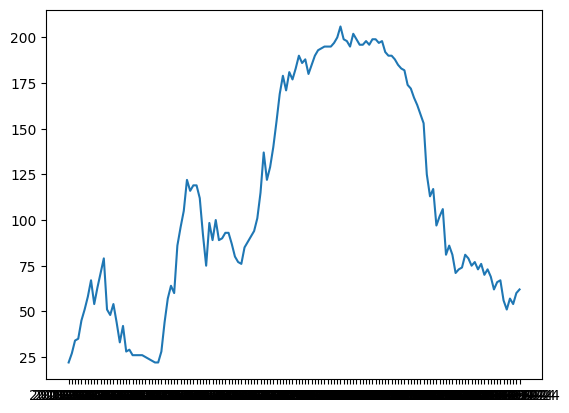

In [34]:
start_index = 20

predictions = o1_rolling_prediction(lcfs, all_news, start_index)

predicted_prices = [pred['price'] for pred in predictions]

# Plot original vs. predicted prices
plt.plot(lcfs['Date'], lcfs['Price'], label='Observed Prices')
plt.plot(lcfs['Date'][start_index:], predicted_prices, label='o1 Predicted Prices', color='r', linestyle=':')
plt.legend()
plt.savefig('/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/LCFS_task/o1+news_pred.png', dpi=300)
plt.show()

print(evaluation(predicted_prices, lcfs['Price'][start_index:]))

In [ ]:
len(predictions)

In [1]:
dates = lcfs['Date'][start_index:]  # Corresponding dates for the predictions

df_predictions = pd.DataFrame({
    'Date': dates,
    'Predicted_Price': predicted_prices,
    'Reason': [pred['reason'] for pred in predictions]
})

df_predictions.to_csv('/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/LCFS_task/o1+news_pred.csv', index=False)

NameError: name 'lcfs' is not defined